In [1]:
# general tools
import os
import sys
import time
import h5py
import random
from glob import glob

import numpy as np
from datetime import datetime, timedelta
from random import shuffle

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend
from keras_unet_collection import utils as k_utils

2023-01-23 12:49:43.567696: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du

In [4]:
import re

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def pos_mixer(TRAIN, L, a0=0, a1=0.2):
    data_shape = TRAIN.shape
    out = np.empty((L, data_shape[-1]))
    
    for i in range(L):
        inds = np.random.choice(data_shape[0], 2)
        a = np.random.uniform(a0, a1)
        out[i, :] = a*TRAIN[inds[0], :] + (1-a)*TRAIN[inds[1], :]
    return out

In [7]:
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [8]:
def verif_metric(VALID_target, Y_pred, ref):


    # fpr, tpr, thresholds = roc_curve(VALID_target.ravel(), Y_pred.ravel())
    # AUC = auc(fpr, tpr)
    # AUC_metric = 1 - AUC
    
    BS = np.mean((VALID_target.ravel() - Y_pred.ravel())**2)
    #ll = log_loss(VALID_target.ravel(), Y_pred.ravel())
    
    #print('{}'.format(BS))
    metric = BS

    return metric / ref

In [9]:
# def set_seeds(seed):
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     random.seed(seed)
#     tf.random.set_seed(seed)
#     np.random.seed(seed)

In [10]:
def feature_extract(filenames, lon_80km, lon_minmax, lat_80km, lat_minmax, elev_80km, elev_max):
    
    lon_out = []
    lat_out = []
    elev_out = []
    mon_out = []
    
    base_v3_s = datetime(2018, 7, 15)
    base_v3_e = datetime(2020, 12, 2)

    base_v4_s = datetime(2020, 12, 3)
    base_v4_e = datetime(2022, 7, 15)

    base_ref = datetime(2010, 1, 1)
    
    date_list_v3 = [base_v3_s + timedelta(days=day) for day in range(365+365+142)]
    date_list_v4 = [base_v4_s + timedelta(days=day) for day in range(365+180-151)]
    
    for i, name in enumerate(filenames):
        
        if 'v4' in name:
            date_list = date_list_v4
        else:
            date_list = date_list_v3
        
        nums = re.findall(r'\d+', name)
        indy = int(nums[-2])
        indx = int(nums[-3])
        day = int(nums[-4])
        day = date_list[day]
        month = day.month
        
        month_norm = (month - 1)/(12-1)
        
        lon = lon_80km[indx, indy]
        lat = lat_80km[indx, indy]

        lon = (lon - lon_minmax[0])/(lon_minmax[1] - lon_minmax[0])
        lat = (lat - lat_minmax[0])/(lat_minmax[1] - lat_minmax[0])

        elev = elev_80km[indx, indy]
        elev = elev / elev_max
        
        lon_out.append(lon)
        lat_out.append(lat)
        elev_out.append(elev)
        mon_out.append(month_norm)
        
    return np.array(lon_out), np.array(lat_out), np.array(elev_out), np.array(mon_out)

def create_model():

    
    IN_vec = keras.Input((512,))    
    IN_elev = keras.Input((3,))
    IN = keras.layers.Concatenate()([IN_vec, IN_elev])
    
    X = IN
    #
    X = keras.layers.Dense(1024, activity_regularizer=keras.regularizers.L2(1e-2))(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Activation("gelu")(X)
    #X = keras.layers.Activation("relu")(X)

    X = keras.layers.Dropout(0.4)(X)
    #X = keras.layers.Dropout(0.2)(X)
    #
    
    X = keras.layers.Dense(512, activity_regularizer=keras.regularizers.L2(1e-2))(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Activation("gelu")(X)
    #X = keras.layers.Activation("relu")(X)
    
    X = keras.layers.Dropout(0.4)(X)
    #X = keras.layers.Dropout(0.2)(X)
    
    X = keras.layers.Dense(128, activity_regularizer=keras.regularizers.L2(1e-2))(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Activation("gelu")(X)
    #X = keras.layers.Activation("relu")(X)
    
    OUT = X
    OUT = keras.layers.Dense(1, activation='sigmoid', bias_initializer=keras.initializers.Constant(-10))(OUT)

    model = keras.models.Model(inputs=[IN_vec, IN_elev], outputs=OUT)
    
    return model

In [11]:
with h5py.File(save_dir+'HRRR_domain.hdf', 'r') as h5io:
    lon_3km = h5io['lon_3km'][...]
    lat_3km = h5io['lat_3km'][...]
    lon_80km = h5io['lon_80km'][...]
    lat_80km = h5io['lat_80km'][...]
    elev_3km = h5io['elev_3km'][...]
    land_mask_80km = h5io['land_mask_80km'][...]
    
grid_shape = land_mask_80km.shape

In [12]:
elev_80km = du.interp2d_wraper(lon_3km, lat_3km, elev_3km, lon_80km, lat_80km, method='linear')

elev_80km[np.isnan(elev_80km)] = 0
elev_80km[elev_80km<0] = 0
elev_max = np.max(elev_80km)

lon_80km_mask = lon_80km[land_mask_80km]
lat_80km_mask = lat_80km[land_mask_80km]

lon_minmax = [np.min(lon_80km_mask), np.max(lon_80km_mask)]
lat_minmax = [np.min(lat_80km_mask), np.max(lat_80km_mask)]

In [13]:
lead1 = 2
lead2 = 3
lead3 = 4
lead4 = 5

lead_name = 4
model_tag = 'full'

In [14]:
filepath_vec = "/glade/work/ksha/NCAR/"

path_name1 = '/glade/scratch/ksha/DATA/NCAR_batch_v3/'
path_name2 = '/glade/scratch/ksha/DATA/NCAR_batch_v3/'
path_name3 = '/glade/scratch/ksha/DATA/NCAR_batch_v3/'
path_name4 = '/glade/scratch/ksha/DATA/NCAR_batch_v3/'

In [15]:
filename_train_lead1 = sorted(glob("{}TRAIN*lead{}.npy".format(path_name1, lead1)))
filename_train_lead2 = sorted(glob("{}TRAIN*lead{}.npy".format(path_name2, lead2)))
filename_train_lead3 = sorted(glob("{}TRAIN*lead{}.npy".format(path_name3, lead3)))
filename_train_lead4 = sorted(glob("{}TRAIN*lead{}.npy".format(path_name4, lead4)))

In [16]:
IND_TRAIN_lead = np.load('/glade/work/ksha/NCAR/IND_TRAIN_lead_full.npy', allow_pickle=True)[()]
TRAIN_ind1 = IND_TRAIN_lead['lead{}'.format(lead1)]
TRAIN_ind2 = IND_TRAIN_lead['lead{}'.format(lead2)]
TRAIN_ind3 = IND_TRAIN_lead['lead{}'.format(lead3)]
TRAIN_ind4 = IND_TRAIN_lead['lead{}'.format(lead4)]

In [17]:
data_lead1_p0 = np.load('{}TRAIN_pp15_pred_lead{}_part0_{}.npy'.format(filepath_vec, lead1, model_tag), allow_pickle=True)[()]
data_lead1_p1 = np.load('{}TRAIN_pp15_pred_lead{}_part1_{}.npy'.format(filepath_vec, lead1, model_tag), allow_pickle=True)[()]
data_lead1_p2 = np.load('{}TRAIN_pp15_pred_lead{}_part2_{}.npy'.format(filepath_vec, lead1, model_tag), allow_pickle=True)[()]

data_lead2_p0 = np.load('{}TRAIN_pp15_pred_lead{}_part0_{}.npy'.format(filepath_vec, lead2, model_tag), allow_pickle=True)[()]
data_lead2_p1 = np.load('{}TRAIN_pp15_pred_lead{}_part1_{}.npy'.format(filepath_vec, lead2, model_tag), allow_pickle=True)[()]
data_lead2_p2 = np.load('{}TRAIN_pp15_pred_lead{}_part2_{}.npy'.format(filepath_vec, lead2, model_tag), allow_pickle=True)[()]

data_lead3_p0 = np.load('{}TRAIN_pp15_pred_lead{}_part0_{}.npy'.format(filepath_vec, lead3, model_tag), allow_pickle=True)[()]
data_lead3_p1 = np.load('{}TRAIN_pp15_pred_lead{}_part1_{}.npy'.format(filepath_vec, lead3, model_tag), allow_pickle=True)[()]
data_lead3_p2 = np.load('{}TRAIN_pp15_pred_lead{}_part2_{}.npy'.format(filepath_vec, lead3, model_tag), allow_pickle=True)[()]

data_lead4_p0 = np.load('{}TRAIN_pp15_pred_lead{}_part0_{}.npy'.format(filepath_vec, lead4, model_tag), allow_pickle=True)[()]
data_lead4_p1 = np.load('{}TRAIN_pp15_pred_lead{}_part1_{}.npy'.format(filepath_vec, lead4, model_tag), allow_pickle=True)[()]
data_lead4_p2 = np.load('{}TRAIN_pp15_pred_lead{}_part2_{}.npy'.format(filepath_vec, lead4, model_tag), allow_pickle=True)[()]

In [18]:
TRAIN_lead1 = np.concatenate((data_lead1_p0['y_vector'], data_lead1_p1['y_vector'], data_lead1_p2['y_vector']), axis=0)
TRAIN_lead2 = np.concatenate((data_lead2_p0['y_vector'], data_lead2_p1['y_vector'], data_lead2_p2['y_vector']), axis=0)
TRAIN_lead3 = np.concatenate((data_lead3_p0['y_vector'], data_lead3_p1['y_vector'], data_lead3_p2['y_vector']), axis=0)
TRAIN_lead4 = np.concatenate((data_lead4_p0['y_vector'], data_lead4_p1['y_vector'], data_lead4_p2['y_vector']), axis=0)

In [19]:
TRAIN_lead1_y = np.concatenate((data_lead1_p0['y_true'], data_lead1_p1['y_true'], data_lead1_p2['y_true']), axis=0)
TRAIN_lead2_y = np.concatenate((data_lead2_p0['y_true'], data_lead2_p1['y_true'], data_lead2_p2['y_true']), axis=0)
TRAIN_lead3_y = np.concatenate((data_lead3_p0['y_true'], data_lead3_p1['y_true'], data_lead3_p2['y_true']), axis=0)
TRAIN_lead4_y = np.concatenate((data_lead4_p0['y_true'], data_lead4_p1['y_true'], data_lead4_p2['y_true']), axis=0)

In [20]:
L = len(TRAIN_ind2)

filename_train1_pick = []
filename_train2_pick = []
filename_train3_pick = []
filename_train4_pick = []

TRAIN_X = np.empty((L, 512))
TRAIN_Y = np.empty(L)

for i in range(L):
    
    ind_lead1 = int(TRAIN_ind1[i])
    ind_lead2 = int(TRAIN_ind2[i])
    ind_lead3 = int(TRAIN_ind3[i])
    ind_lead4 = int(TRAIN_ind4[i])
    
    filename_train1_pick.append(filename_train_lead1[ind_lead1])
    filename_train2_pick.append(filename_train_lead2[ind_lead2])
    filename_train3_pick.append(filename_train_lead3[ind_lead3])
    filename_train4_pick.append(filename_train_lead4[ind_lead4])
    
    TRAIN_X[i, 0:128]   = TRAIN_lead1[ind_lead1, :]
    TRAIN_X[i, 128:256] = TRAIN_lead2[ind_lead2, :]
    TRAIN_X[i, 256:384] = TRAIN_lead3[ind_lead3, :]
    TRAIN_X[i, 384:512] = TRAIN_lead4[ind_lead4, :]
    
    TRAIN_Y[i] = TRAIN_lead3_y[ind_lead3]

In [21]:
lon_norm, lat_norm, elev_norm, mon_norm = feature_extract(
    filename_train3_pick, lon_80km, lon_minmax, lat_80km, lat_minmax, elev_80km, elev_max)

In [22]:
TRAIN_stn = np.concatenate((lon_norm[:, None], lat_norm[:, None], elev_norm[:, None]), axis=1)
TRAIN_merge = TRAIN_stn

In [23]:
TRAIN_256_pos = TRAIN_X[TRAIN_Y==1, :]
TRAIN_256_neg = TRAIN_X[TRAIN_Y==0, :]

In [24]:
TRAIN_stn_pos = TRAIN_merge[TRAIN_Y==1]
TRAIN_stn_neg = TRAIN_merge[TRAIN_Y==0]

**Valid**

In [25]:
filename_valid_lead1 = sorted(glob("{}VALID*lead{}.npy".format(path_name1, lead1)))
filename_valid_lead2 = sorted(glob("{}VALID*lead{}.npy".format(path_name2, lead2)))
filename_valid_lead3 = sorted(glob("{}VALID*lead{}.npy".format(path_name3, lead3)))
filename_valid_lead4 = sorted(glob("{}VALID*lead{}.npy".format(path_name4, lead4)))

In [26]:
valid_lead1 = np.load('{}TEST_pp15_pred_lead{}_{}.npy'.format(filepath_vec, lead1, model_tag), allow_pickle=True)[()]
valid_lead2 = np.load('{}TEST_pp15_pred_lead{}_{}.npy'.format(filepath_vec, lead2, model_tag), allow_pickle=True)[()]
valid_lead3 = np.load('{}TEST_pp15_pred_lead{}_{}.npy'.format(filepath_vec, lead3, model_tag), allow_pickle=True)[()]
valid_lead4 = np.load('{}TEST_pp15_pred_lead{}_{}.npy'.format(filepath_vec, lead4, model_tag), allow_pickle=True)[()]

VALID_lead1 = valid_lead1['y_vector']
VALID_lead2 = valid_lead2['y_vector']
VALID_lead3 = valid_lead3['y_vector']
VALID_lead4 = valid_lead4['y_vector']

VALID_lead1_y = valid_lead1['y_true']
VALID_lead2_y = valid_lead2['y_true']
VALID_lead3_y = valid_lead3['y_true']
VALID_lead4_y = valid_lead4['y_true']

In [27]:
IND_VALID_lead = np.load('/glade/work/ksha/NCAR/IND_VALID_lead_full.npy', allow_pickle=True)[()]

VALID_ind1 = IND_VALID_lead['lead{}'.format(lead1)]
VALID_ind2 = IND_VALID_lead['lead{}'.format(lead2)]
VALID_ind3 = IND_VALID_lead['lead{}'.format(lead3)]
VALID_ind4 = IND_VALID_lead['lead{}'.format(lead4)]

In [28]:
L = len(VALID_ind3)

filename_valid1_pick = []
filename_valid2_pick = []
filename_valid3_pick = []
filename_valid4_pick = []

VALID_X = np.empty((L, 512))
VALID_Y = np.zeros(L)

for i in range(L):
    
    ind_lead1 = int(VALID_ind1[i])
    ind_lead2 = int(VALID_ind2[i])
    ind_lead3 = int(VALID_ind3[i])
    ind_lead4 = int(VALID_ind4[i])
    
    filename_valid1_pick.append(filename_valid_lead1[ind_lead1])
    filename_valid2_pick.append(filename_valid_lead2[ind_lead2])
    filename_valid3_pick.append(filename_valid_lead3[ind_lead3])
    filename_valid4_pick.append(filename_valid_lead4[ind_lead4])
    
    VALID_X[i, 0:128]   = VALID_lead1[ind_lead1, :]
    VALID_X[i, 128:256] = VALID_lead2[ind_lead2, :]
    VALID_X[i, 256:384] = VALID_lead3[ind_lead3, :]
    VALID_X[i, 384:512] = VALID_lead4[ind_lead4, :]
    
    if 'pos' in filename_valid_lead3[ind_lead3]:
        if VALID_lead3_y[ind_lead3] == 1.0:
            VALID_Y[i] = 1.0
        else:
            egwrshat
        

In [29]:
lon_norm, lat_norm, elev_norm, mon_norm = feature_extract(
    filename_valid3_pick, lon_80km, lon_minmax, lat_80km, lat_minmax, elev_80km, elev_max)

In [30]:
VALID_stn = np.concatenate((lon_norm[:, None], lat_norm[:, None], elev_norm[:, None]), axis=1)
VALID_merge = VALID_stn

In [31]:
seeds = [12342, 2536234, 98765, 473, 865, 7456, 69472, 3456357, 3425, 678,
         2452624, 5787, 235362, 67896, 98454, 12445, 46767, 78906, 345, 8695, 
         2463725, 4734, 23234, 884, 2341, 362, 5, 234, 483, 785356, 23425, 3621, 
         58461, 80968765, 123, 425633, 5646, 67635, 76785, 34214]

training_rounds = len(seeds)

In [32]:
ref = np.sum(VALID_Y) / len(VALID_Y)

# =========== Model Section ========== #

batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'FULL_Lead{}'.format(lead_name)

model_name = '{}'.format(key)
model_path = temp_dir+model_name

tol = 0

# ========== Training loop ========== #
L_pos = len(TRAIN_256_pos)
L_neg = len(TRAIN_256_neg)

record = 1.1
print("Initial record: {}".format(record))

min_del = 0
max_tol = 100 # early stopping with patience

epochs = 500
batch_size = 64
L_train = 16

for r in range(training_rounds):
    if r == 0:
        tol = 0
    else:
        tol = -200

    model = create_model()
    #
    model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(lr=1e-4))
    
    set_seeds(int(seeds[r]))
    print('Training round {}'.format(r))

    for i in range(epochs):            
        start_time = time.time()

        # loop of batch
        for j in range(L_train):
            N_pos = 32
            N_neg = batch_size - N_pos

            ind_neg = du.shuffle_ind(L_neg)
            ind_pos = du.shuffle_ind(L_pos)

            ind_neg_pick = ind_neg[:N_neg]
            ind_pos_pick = ind_pos[:N_pos]

            X_batch_neg = TRAIN_256_neg[ind_neg_pick, :]
            X_batch_pos = TRAIN_256_pos[ind_pos_pick, :]
            
            X_batch_stn_neg = TRAIN_stn_neg[ind_neg_pick, :]
            X_batch_stn_pos = TRAIN_stn_pos[ind_pos_pick, :]

            X_batch = np.concatenate((X_batch_neg, X_batch_pos), axis=0)
            X_batch_stn = np.concatenate((X_batch_stn_neg, X_batch_stn_pos), axis=0)

            Y_batch = np.ones([batch_size,])
            Y_batch[:N_neg] = 0.0

            ind_ = du.shuffle_ind(batch_size)

            X_batch = X_batch[ind_, :]
            X_batch_stn = X_batch_stn[ind_, :]
            Y_batch = Y_batch[ind_]

            # train on batch
            model.train_on_batch([X_batch, X_batch_stn], Y_batch);

        # epoch end operations
        Y_pred = model.predict([VALID_X, VALID_merge])

        Y_pred[Y_pred<0] = 0
        Y_pred[Y_pred>1] = 1

        record_temp = verif_metric(VALID_Y, Y_pred, ref)

        # if i % 10 == 0:
        #     model.save(model_path_backup)

        if (record - record_temp > min_del):
            print('Validation loss improved from {} to {}'.format(record, record_temp))
            record = record_temp
            tol = 0
            
            #print('tol: {}'.format(tol))
            # save
            print('save to: {}'.format(model_path))
            model.save(model_path)
        else:
            print('Validation loss {} NOT improved'.format(record_temp))
            if record_temp > 1.0:
                print('Early stopping')
                break;
            else:
                tol += 1
                if tol >= max_tol:
                    print('Early stopping')
                    break;
                else:
                    continue;
        print("--- %s seconds ---" % (time.time() - start_time))

Initial record: 1.1


2023-01-23 12:51:32.381121: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-23 12:51:32.382572: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-01-23 12:51:32.426652: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:61:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-01-23 12:51:32.426700: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-01-23 12:51:32.430299: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-01-23 12:51:32.430360: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

Training round 0


2023-01-23 12:51:34.427560: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-01-23 12:51:34.432170: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2600000000 Hz
2023-01-23 12:51:34.557798: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


Validation loss improved from 1.1 to 0.9987818994906662
save to: /glade/work/ksha/NCAR/Keras_models/FULL_Lead4


2023-01-23 12:51:47.294875: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/FULL_Lead4/assets
--- 15.259850263595581 seconds ---
Validation loss 0.9996656377193046 NOT improved
Validation loss 0.9997496874444752 NOT improved
Validation loss 0.9997513789760539 NOT improved
Validation loss 0.9997495163200771 NOT improved
Validation loss 0.9997154445649221 NOT improved
Validation loss 0.9996114123019266 NOT improved
Validation loss 0.9995980718876463 NOT improved
Validation loss 0.9993071194042602 NOT improved
Validation loss 0.9993064075931078 NOT improved
Validation loss improved from 0.9987818994906662 to 0.9983984082501626
save to: /glade/work/ksha/NCAR/Keras_models/FULL_Lead4
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/FULL_Lead4/assets
--- 9.446533918380737 seconds ---
Validation loss improved from 0.9983984082501626 to 0.9983531059770668
save to: /glade/work/ksha/NCAR/Keras_models/FULL_Lead4
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/F


KeyboardInterrupt



In [34]:
seeds[r]

5646523431

In [33]:
model = create_model()

model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=keras.optimizers.Adam(lr=0))

W_old = k_utils.dummy_loader('/glade/work/ksha/NCAR/Keras_models/full_lead{}/'.format(lead_name))
model.set_weights(W_old)

In [34]:
ref = np.sum(VALID_Y) / len(VALID_Y)
Y_pred = model.predict([VALID_X, VALID_merge])
record_temp = verif_metric(VALID_Y, Y_pred, ref)

In [35]:
# save_dict = {}
# save_dict['Y_pred'] = Y_pred
# save_dict['VALID_Y'] = VALID_Y
# np.save('{}RESULT_BASE_lead{}_base.npy'.format(filepath_vec, lead), save_dict)
# print('{}RESULT_BASE_lead{}_base.npy'.format(filepath_vec, lead))

In [36]:
record_temp

0.8896413030101082

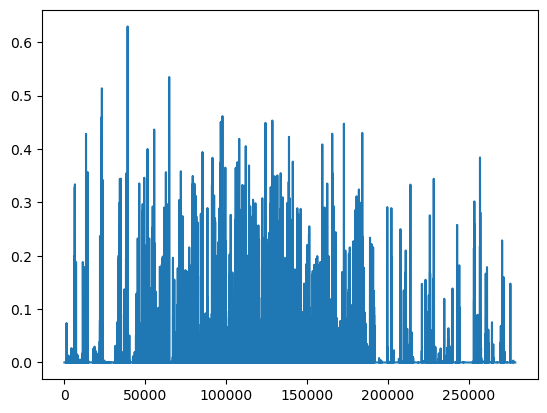

In [37]:
plt.plot(Y_pred)

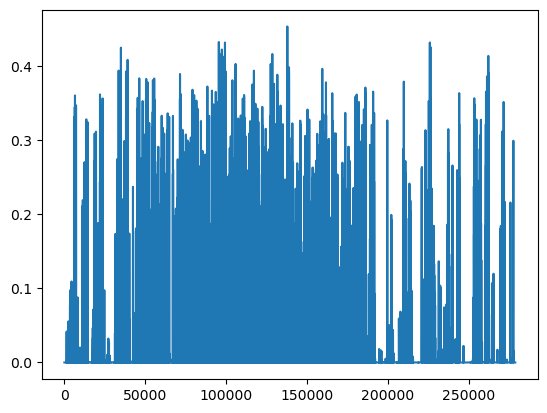

In [53]:
plt.plot(Y_pred)

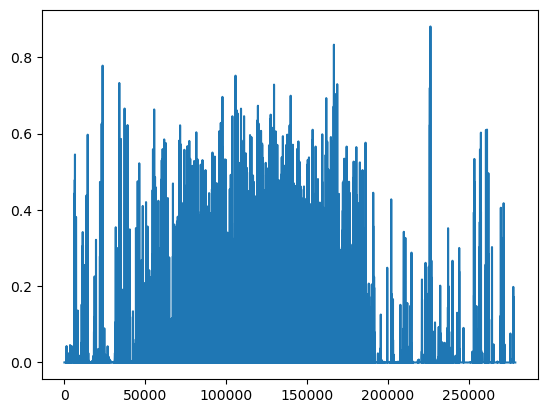

In [51]:
plt.plot(Y_pred)